# Create new utility function

Import data.

In [1]:
%load_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1

import dgym as dg

# load all data
print('load data')
path = '../../dgym-data'

deck = dg.MoleculeCollection.from_sdf(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

load data


In [2]:
building_blocks = dg.datasets.enamine(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/out/Enamine_Building_Blocks_Stock_262336cmpd_20230630.fpb')

# align fingerprints to building blocks
print('align fingerprints')
fingerprints = dg.utils.sort_fingerprints(fingerprints, building_blocks)

# partition building blocks according to functional groups
print('partition building blocks')
templates = dg.utils.get_unique_reactants(reactions)
building_blocks = dg.utils.partition_building_blocks(building_blocks, templates, out_dir=path)

align fingerprints
partition building blocks


Create inputs to the DrugEnv.

In [64]:
import numpy as np
from dgym.envs.library_designer import LibraryDesigner
from dgym.envs.oracle import DGLOracle, RDKitOracle
from dgym.envs.evaluator import ClassicEvaluator, UtilityFunction

# create library designer
library_designer = LibraryDesigner(
    reactions,
    building_blocks,
    fingerprints
)

# create assays
log_P_oracle = RDKitOracle('MolLogP')
log_S_oracle = DGLOracle('GCN_canonical_ESOL')
assays = [log_S_oracle, log_P_oracle]

# create evaluators
# ideal = (-2, 0)
log_S_evaluator = ClassicEvaluator(ideal=(-2, 0), acceptable=(-4, 0.5))
# ideal = (1, 4)
log_P_evaluator = ClassicEvaluator(ideal=(1, 4), acceptable=(0, 5))

# create utility function
utility_function = UtilityFunction(
    evaluators = [log_S_evaluator, log_P_evaluator],
    strategy = lambda x: np.prod(x)
)

utility = [utility_function(p) for p in zip(*[assay(deck) for assay in assays])]
worst_molecules = np.argsort(assays[0](deck))[:25].tolist()

(-3.0, 6.0)

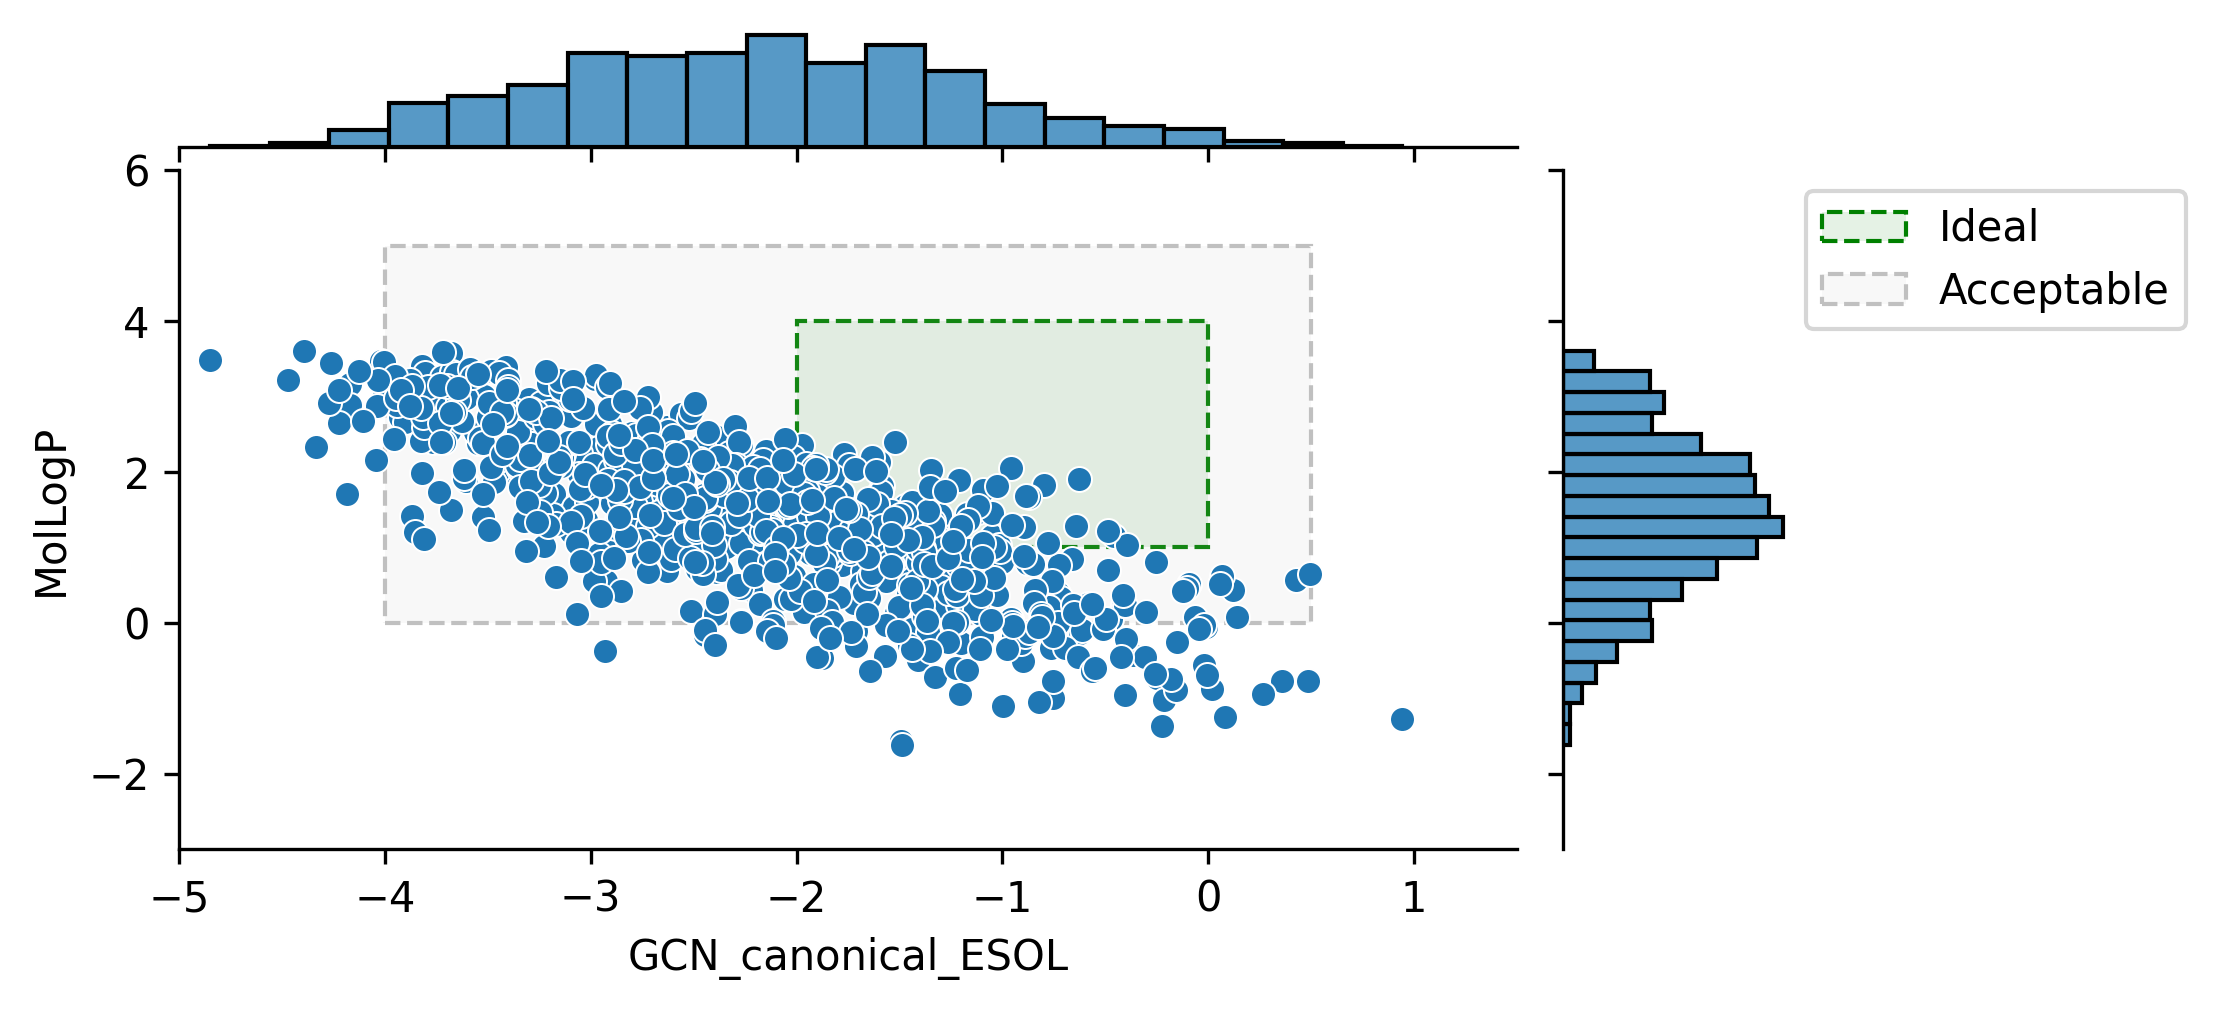

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt

worst_deck = deck
assay_results = [assay(worst_deck) for assay in assays]
g = dg.plot(
    assay_results,
    assays,
    [utility_function(p) for p in zip(*assay_results)],
    utility_function
)

g.ax_joint.set_xlim(-5, 1.5)
g.ax_joint.set_ylim(-3, 6)

First, set up the environment.

In [73]:
from dgym.envs.drug_env import DrugEnv
from dgym.agents import HardcodedDrugAgent
from tqdm.notebook import tqdm

results = []
for trial in tqdm(range(100)):
    
    drug_env = DrugEnv(
        library_designer,
        library = deck[worst_molecules],
        assays = assays,
        budget = 10_000,
        utility_function=utility_function,
    )

    drug_agent = HardcodedDrugAgent(
        action_space=drug_env.action_space,
        scoring_functions=assays,
        utility_function=utility_function,
        epsilon=1.0,
        fraction_random=1.0,
        num_analogs=1,
        branch_factor=5
    )

    observations, info = drug_env.reset()

    while True:
        action = drug_agent.act(observations)
        observations, reward, terminated, truncated, info = drug_env.step(action)
        result = {'trial': trial}

        if terminated:
            result.update({'cost': len(drug_env.library) - len(drug_env._library_0), 'outcome': 1})
            break

        if truncated:
            result.update({'outcome': 0})
            break

    results.append(result)

  0%|          | 0/100 [00:00<?, ?it/s]

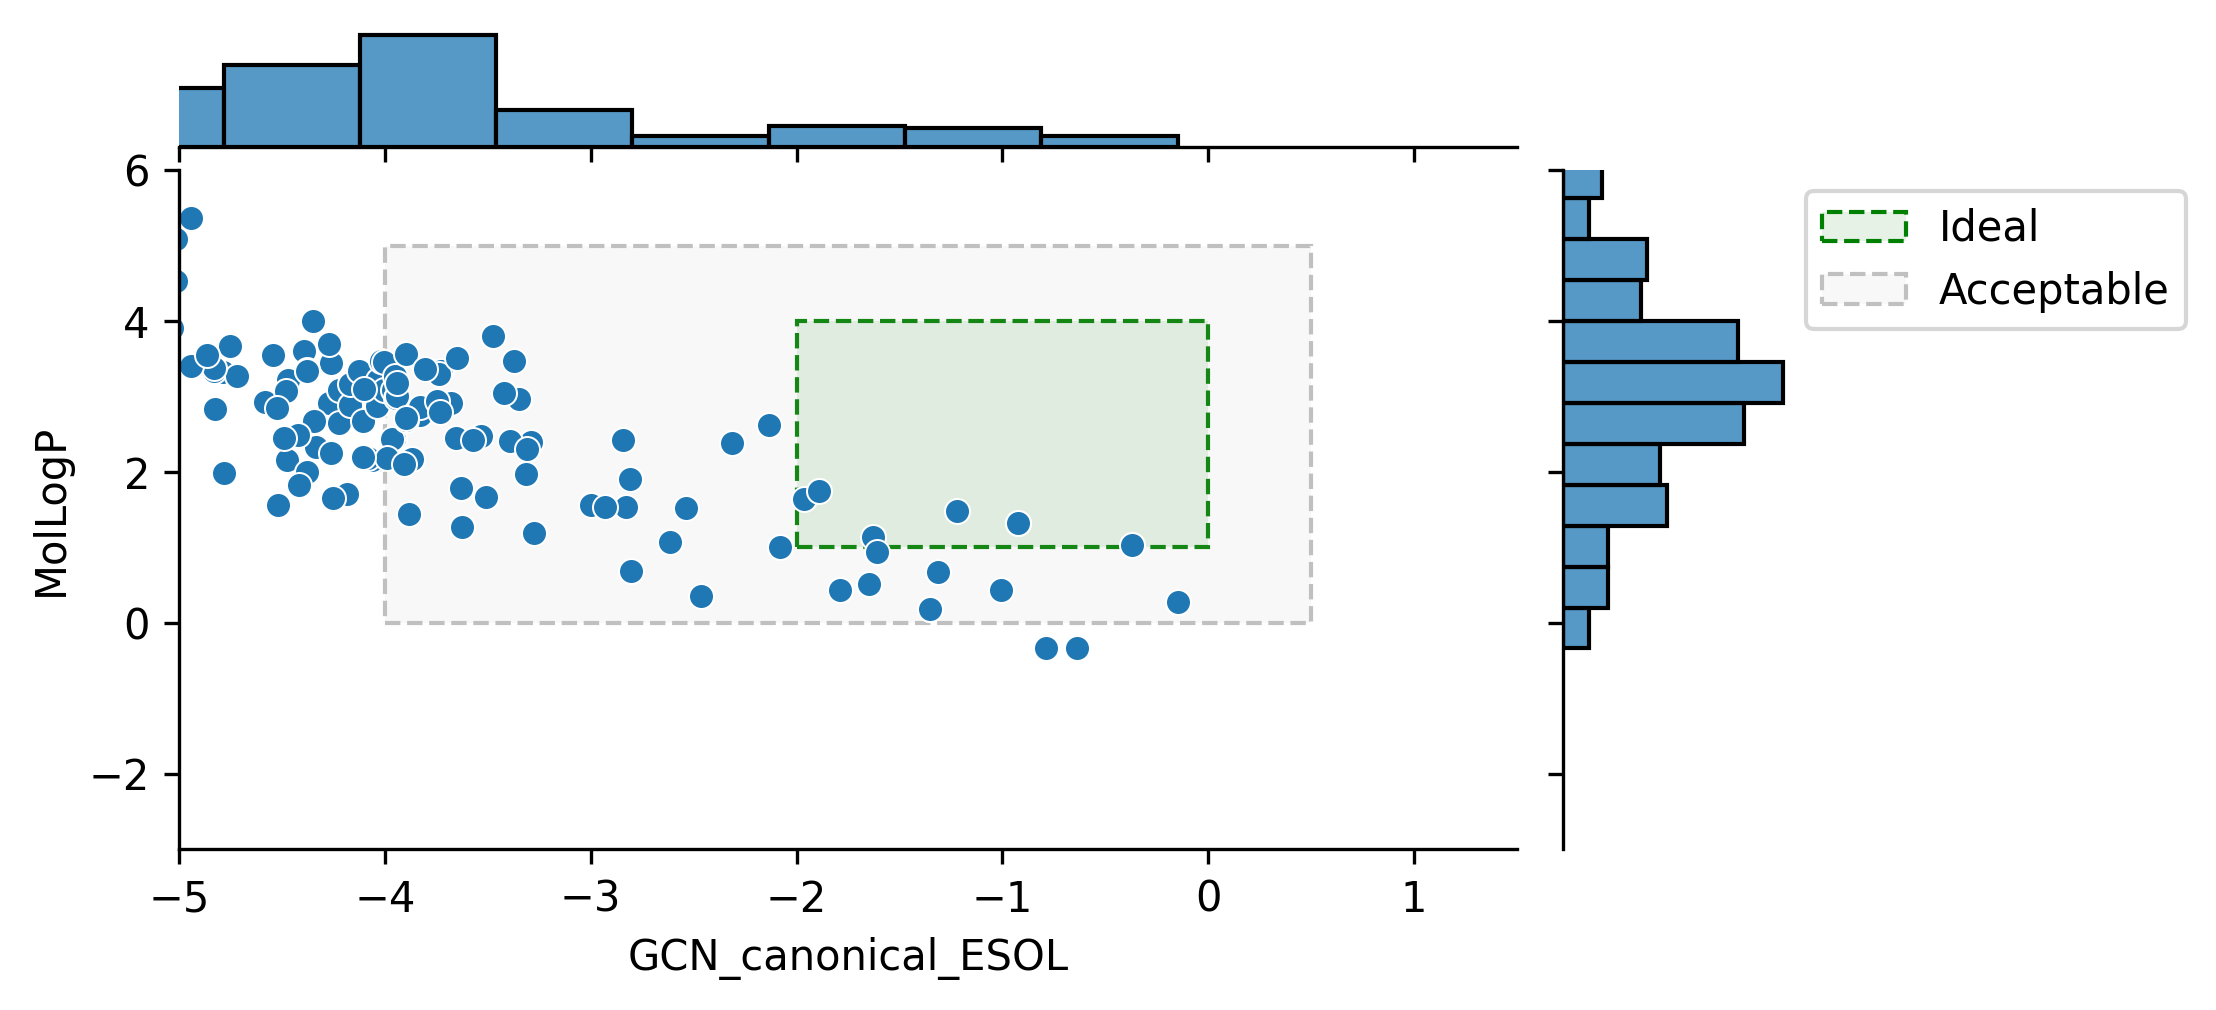

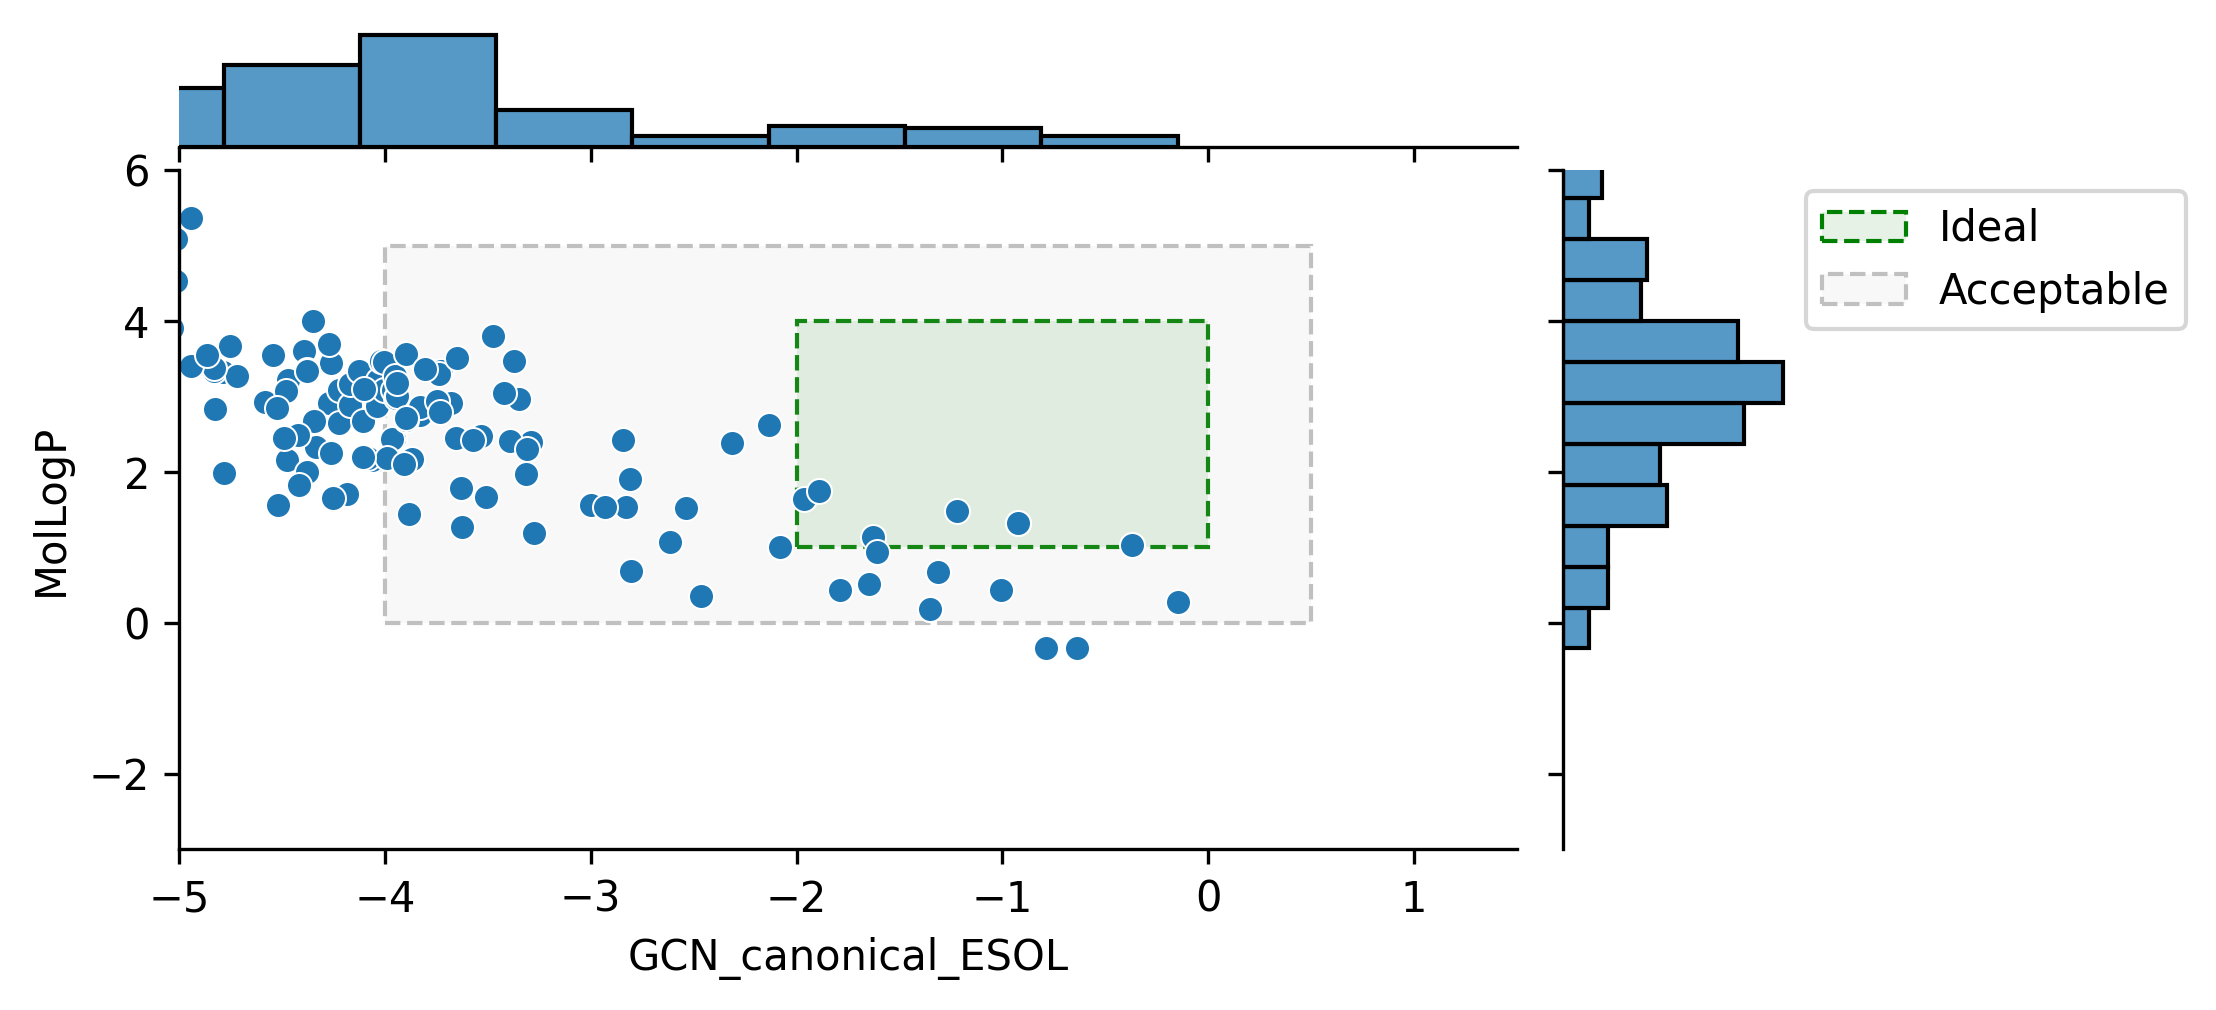

In [122]:
sns.reset_defaults()
assay_results = [assay(drug_env.library) for assay in assays]
g = dg.plot(
    assay_results,
    assays,
    [utility_function(p) for p in zip(*assay_results)],
    utility_function
)

g.ax_joint.set_xlim(-5, 1.5)
g.ax_joint.set_ylim(-3, 6)
plt.show()

In [94]:
def ecdf(costs):
    costs = np.array([c for c in costs])
    costs_sorted = np.sort(costs)
    probs = 1. * np.arange(1, len(costs) + 1) / len(costs)

    costs_sorted = np.concatenate([[0.0], costs_sorted])
    probs = np.concatenate([[0.0], probs])
    
    return costs_sorted, probs

In [106]:
import pandas as pd
df = pd.read_csv(
    ('../../dgym-data/'
     'out/experiments/'
     'hardcoded_num_analogs=10_branch_factor=5_epsilon=0.33_frac_rand=0.2.csv'),
     index_col=0)

epsilon_greedy = pd.DataFrame(zip(*ecdf(df['cost'])), columns=['cost', 'probs'])
epsilon_greedy['strategy'] = 'epsilon_greedy'

In [107]:
random = pd.DataFrame(
    zip(*ecdf([r['cost'] for r in results])),
    columns=['cost', 'probs']
)
random['strategy'] = 'random'

df = pd.concat([random, epsilon_greedy])

(0.0, 400.0)

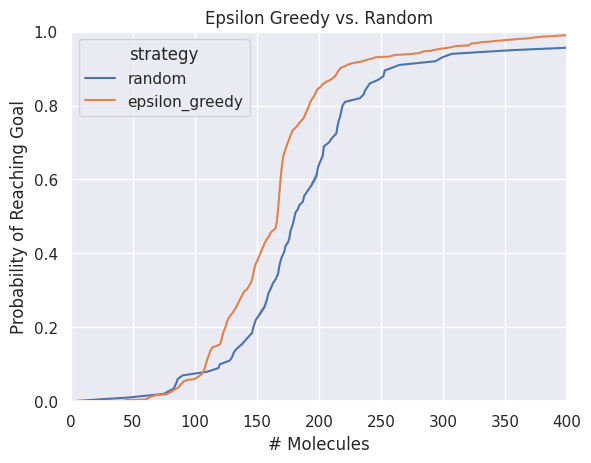

In [119]:
sns.set()
g = sns.lineplot(
    data=df,
    x='cost',
    y='probs',
    hue='strategy'
)
g.set_title('Epsilon Greedy vs. Random')
g.set_xlabel('# Molecules')
g.set_ylabel('Probability of Reaching Goal')
g.set_ylim([0, 1])
g.set_xlim(0, 400)

In [118]:
df.query('cost == 199.')

,cost,probs,strategy
63,199.0,0.630,random
844,199.0,0.844,epsilon_greedy
845,199.0,0.845,epsilon_greedy
846,199.0,0.846,epsilon_greedy


In [133]:
display(df.query('strategy == "random"').query('probs == 0.5'))
display(df.query('strategy == "epsilon_greedy"').query('probs == 0.5'))

,cost,probs,strategy
50,180.0,0.5,random


,cost,probs,strategy
500,166.0,0.5,epsilon_greedy


Draw lineage of best molecule.

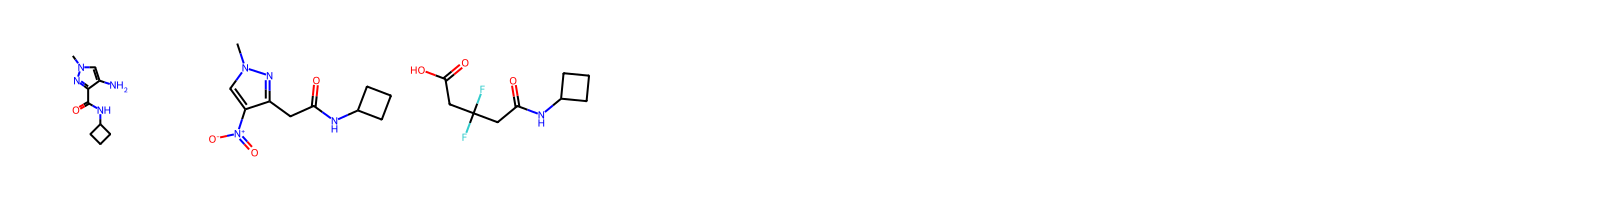

0.6207067290842531		0.6106847879787286		1


(-1.2017120122909546, 0.2845999999999995)

(-2.2398717403411865, 0.5394999999999999)

(-0.9800273180007935, 1.1551999999999998)

In [339]:
from rdkit.Chem import Draw

utility = drug_agent.policy(observations)
index = int(np.argsort(utility)[-1])

mol = drug_env.library[index]
lineage = [mol]
while mol.inspiration:
    mol = mol.inspiration
    lineage.insert(0, mol)

assay_results = [assay(lineage) for assay in assays]
results = [
    utility_function.score(properties)
    for properties in zip(*assay_results)
]

display(Draw.MolsToGridImage(
    [m.mol for m in lineage],
    molsPerRow=8,
    maxMols=10_000
))

print('\t\t'.join(map(str, results)))
display(*zip(*assay_results))